<a href="https://colab.research.google.com/github/AnaNava1996/Proyecto_Bedu/blob/main/Entrega_Final_MachineLearning_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/Proyecto_Equipo10_Incendios_Forestales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de Incendios Forestales**
### Proyecto BEDU Data Science, Modulo Final
* Eréndira Celis Acosta
* Ana Paola Nava Vivas
* Hegar José García Rodríguez
* Gerardo Leonel García Pegueros

# Instalaciones

In [22]:
! pip install geopandas rtree
! apt install libspatialindex-dev
! pip install --upgrade plotly
! pip install tensorflow
! pip install keras_metrics

     |████████████████████████████████| 1.0MB 4.9MB/s 
     |████████████████████████████████| 1.0MB 38.6MB/s 
     |████████████████████████████████| 15.4MB 188kB/s 
     |████████████████████████████████| 6.6MB 34.9MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]

# Introducción

# Clusterización con K-means

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [ ]:
def fetch_fire_dataset(year):
  base_url = "https://firms.modaps.eosdis.nasa.gov/data/country/modis"
  current_url = f"{base_url}/{year}/modis_{year}_Mexico.csv"
  return pd.read_csv(current_url)

In [ ]:
fire_data = pd.concat(list(map(fetch_fire_dataset, range(2000,2020))), axis=0)
filtro_alta_confianza = fire_data['confidence'] > 90
filtro_incendios = fire_data['type'] == 0
fire_data = fire_data[filtro_alta_confianza & filtro_incendios][['longitude','latitude']]

In [ ]:
fire_data.shape

(126941, 2)

In [ ]:
X = fire_data[['latitude','longitude']].values

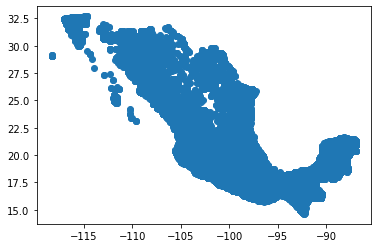

In [ ]:
plt.scatter(fire_data['longitude'],fire_data['latitude'])
plt.show()

In [ ]:
iris_dbscan = DBSCAN(eps=20/6371, min_samples=100,algorithm='ball_tree', metric='haversine')

In [ ]:
iris_dbscan.fit(np.radians(X))

DBSCAN(algorithm='ball_tree', eps=0.0031392246115209545, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=100, n_jobs=None,
       p=None)

In [ ]:
labels = iris_dbscan.labels_

In [ ]:
# label=-1 means the point is an outlier. Rest of the values represent the label/cluster number starting from 0
print(labels)

[ 1 -1 -1 ... 26  2  1]


In [ ]:
# Creating a numpy array with all values set to false by default
core_samples_mask = np.zeros_like(labels, dtype=bool)

In [ ]:
# Setting core and border points (all points that are not -1) to True
core_samples_mask[iris_dbscan.core_sample_indices_] = True

In [ ]:
# Finding the number of clusters in labels (ignoring noise if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [ ]:
# Printing the number of clusters and number of noise points (outliers)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 53
Estimated number of noise points: 13618


AQUI se tarda (se puede saltar esta celda y seguir con las demás):

In [ ]:
# Evaluating the quality of clusters
s = metrics.silhouette_score(X, iris_dbscan.labels_)
print(f'Silhouette Coefficient for the Iris Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the Iris Dataset Clusters: -0.19


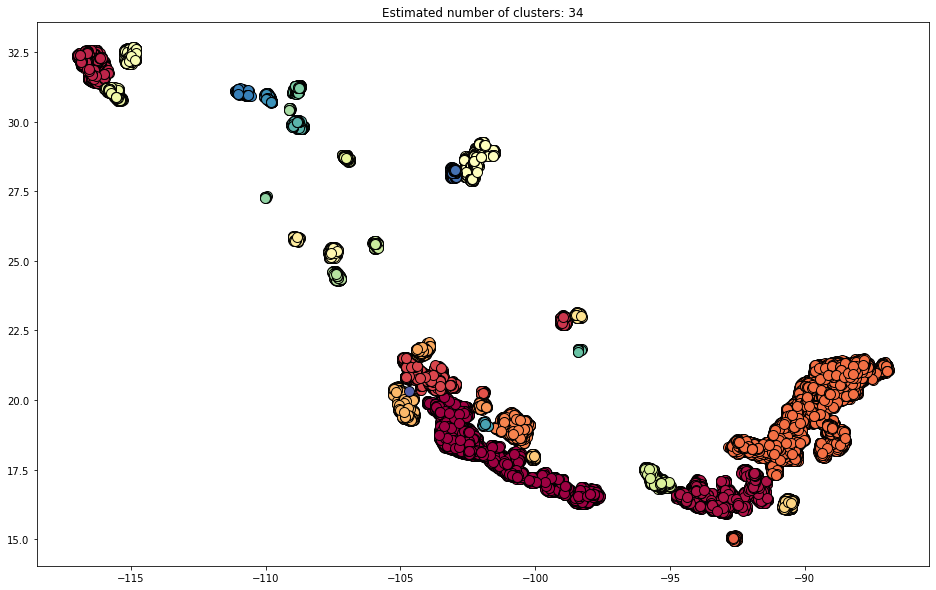

In [ ]:
unique_labels = set(labels)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = 'k'
    
    class_member_mask = (labels == k)
    #xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
    #markeredgecolor='k', markersize=2)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
    markeredgecolor='k', markersize=10)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

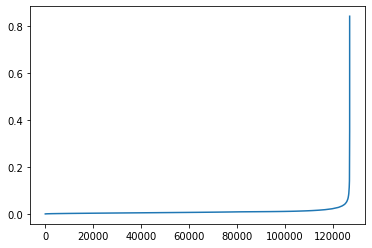

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)[:, 1]
#print(distances)
plt.plot(distances)
plt.show()

# Predicción de tiempo.

Como vimos en entregas anteriores, existía cierta relación entre la fecha del año y la cantidad de incendios por ecorregión.

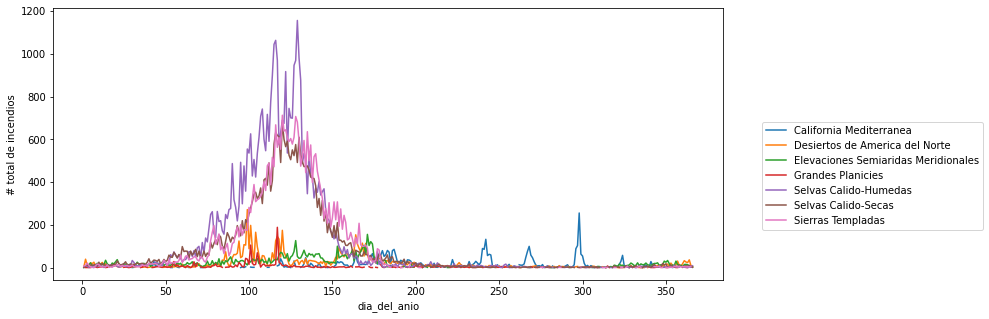

En el caso de las ecorregiones de nivel 1, escogimos arbitrariamente la de Selvas Cálido Húmedas ya que presentaba el pico más alto en incendios y nos llamó la atención.


Se analizó la correlación con un Scatterplot y se observó que no había correlación de Pearson entre el día del año y el número de incendios. Sin embargo, corroborabos que año tras años los puntos se concentraban hacia ciertos días del año que correspondían a las temporadas de sequía.

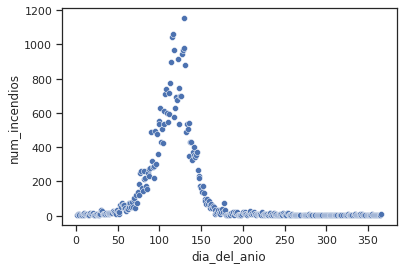

# Regresión Lineal

En algún momento nos planteamos realizar regresiones lineales por temporadas del año, como se ve a continuación donde se acotó del día 1 al 125 del año.

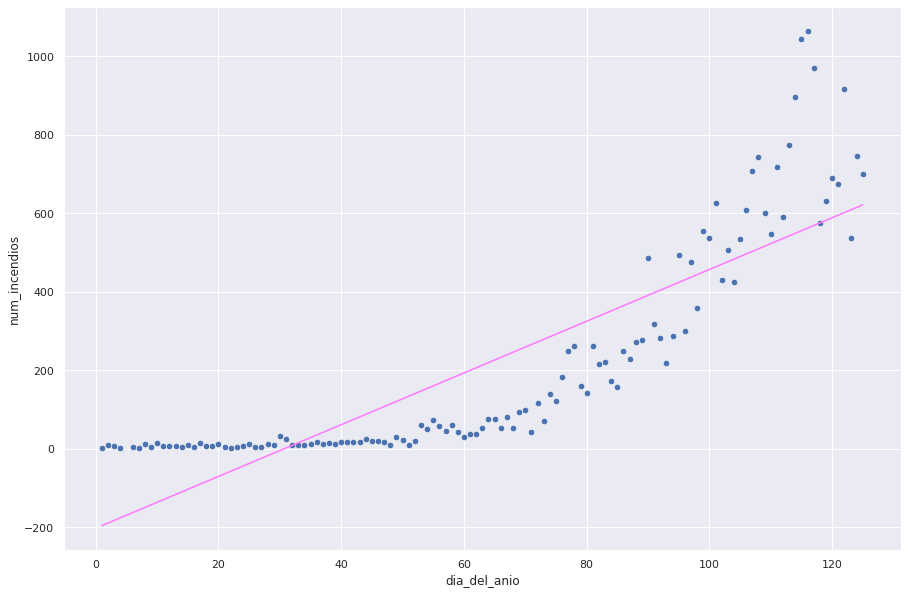

Pero siendo sinceros era una mala aproximación. Es por esto que buscamos otras soluciones.

# Predicción con SARIMA, "Seasonality-Autorgresive-Integrated-Moving Average"

En nuestra investigación nos encontramos con el algoritmo de Sarima que es un Arima agregando un factor de "Seasonality" puesto que nuestro caso de estudio cumplía con patrones en el año. Sin embargo posteriormente descartamos este algoritmo ya que las predicciones no eran lo suficientemente buenas y existía un retraso en las mismas con respecto al control incluso tras intentar diversos ajustes.

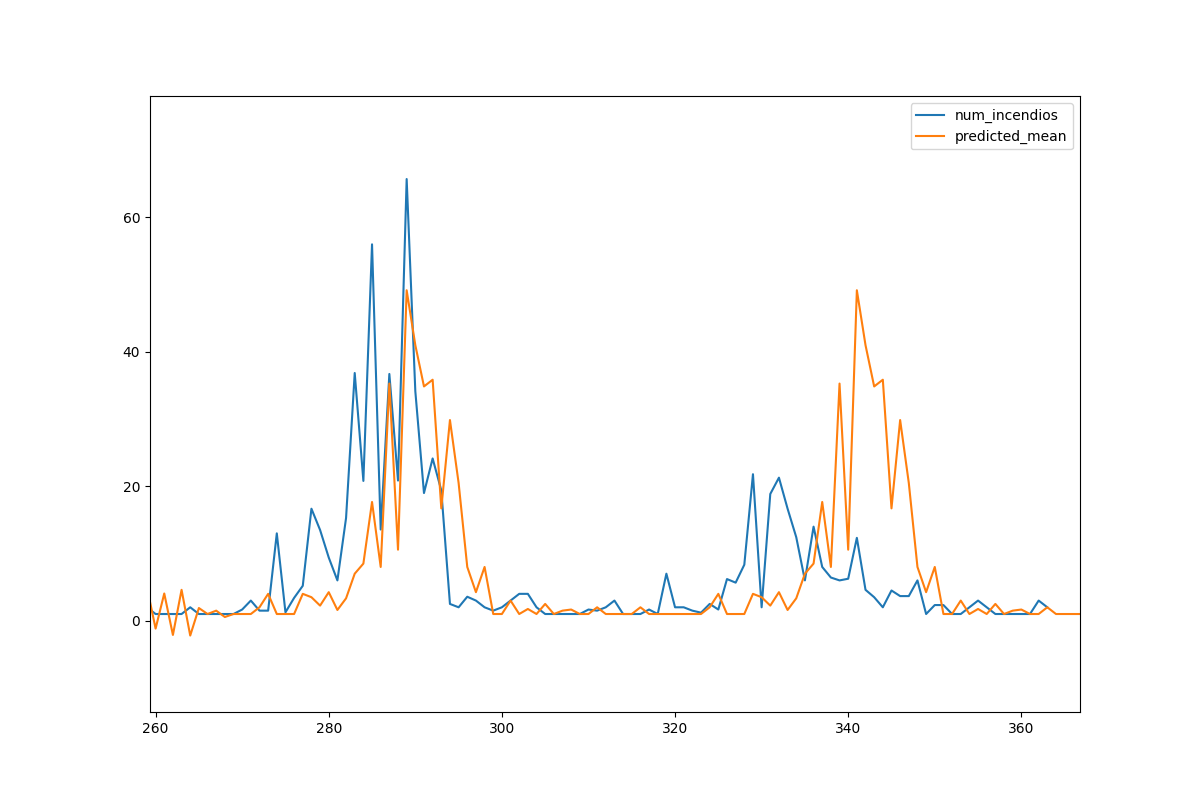

Para ver el código de Sarima, dar click [aquí](https://github.com/AnaNava1996/Proyecto_Bedu/blob/main/Entrega_Final_MachineLearning_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/otros_programas/sarima.py)

Sarima no funcionó porque no es un buen modelo cuando se tienen tantos datos. evidentemente existe un patrón que se repite año tras año, y con Sarima habría sido mejor medir en lugar de días, los meses... y eso no nos interesaba porque queríamos obtener el valor de 1 día específico.

# Predicción utilizando LSTM 🎉

Una opción era usar deep learning para este problema, como vimos en clase una red puede equivaler a una regresión logística.

Entre las opciones estaba la "Recurrent Neural Network" (RNN), pero es una red que presenta un problema de "vanishing gradient" ya que en cada "back propagation" disminuyen las gradientes y por lo tanto los pesos y bias dejan de actualizarse, es decir, el algoritmo deja de aprender.

A diferencia de las RNN, las LSTM o "Long Short Term Memory" no sufren del problema de gradiente que se desvanece, y son mejores para aprender con sets de datos muy largos. Es como si tuvieran memoria a largo y corto plazo.

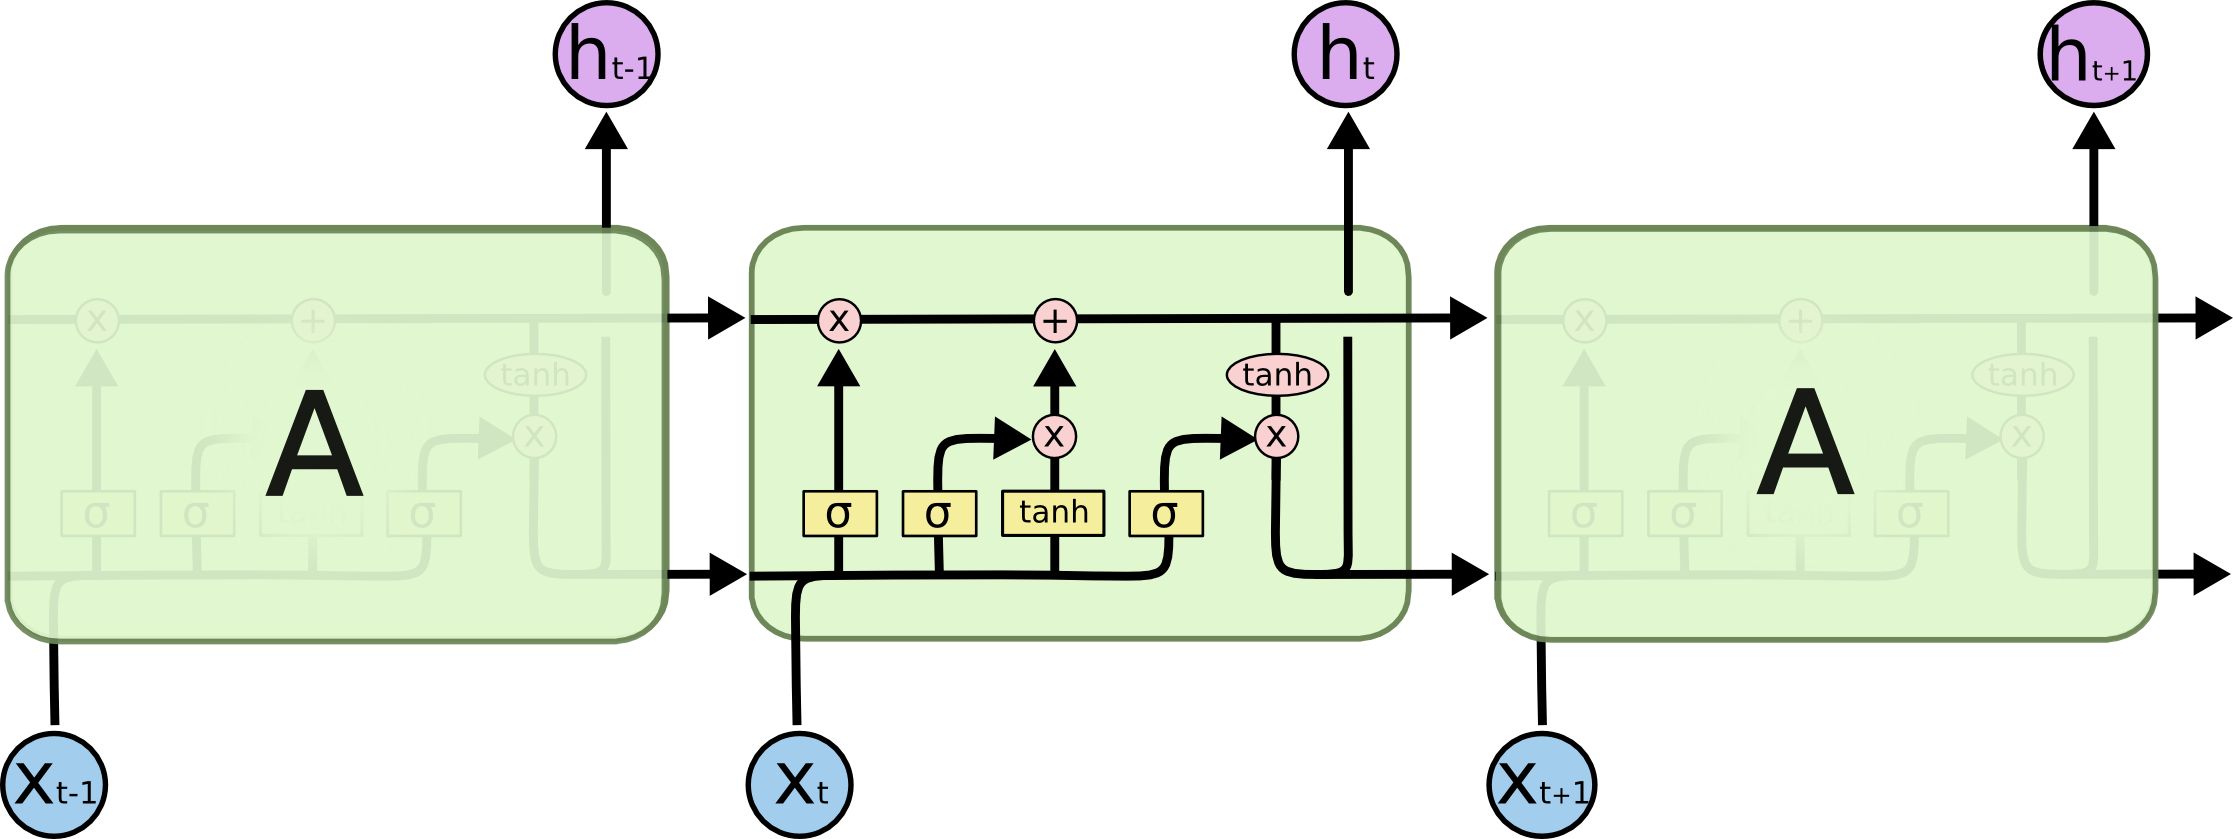

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras_metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Vamos a crear una función para retornar dos arreglos de numpy basados en el set de datos que ya tenemos. El parámetro de look_back tendrá por defecto el valor de 30 que corresponde a aproximadamente un mes.

In [68]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])#tomo 30 fechas - de fila de 0 a 29
        dataY.append(dataset[i + look_back, 0])#tomo la fecha 30... y asi sucesivamente...
    
    return np.array(dataX), np.array(dataY)


In [69]:
#Función que le añade las fechas restantes en ceros. USO: df = makeDate(df)
def makeDate(df,begin=True):
    df.fecha = pd.to_datetime(df.fecha)
    print(df)
    df['día'] = df.fecha.dt.day
    #df['semana'] = fdf.index.week
    df['mes'] = df.fecha.dt.month
    df['año'] = df.fecha.dt.year
    df = df.groupby(['año','mes','día'],as_index=True).sum().reset_index()
    
    df['fecha'] = df[['año','mes','día']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    if begin: df.fecha = pd.to_datetime(df.fecha)
    df.set_index(['fecha'],inplace=True)
    idx = pd.date_range(min(df.index), max(df.index))
    df = df.reindex(idx,fill_value=0)
    df.drop(['año','mes','día'], axis = 1, inplace=True)
    return df

Vamos a abrir el data set de incendios en las ecorregiones de tipo 1 por fechas, que obtuvimos en módulos anteriores. En este caso vamos a filtrar y predecir las Selvas Cálido Húmedas.

In [70]:
columna = 'ecorregion_nivel_1'

df = pd.read_csv("https://raw.githubusercontent.com/AnaNava1996/Proyecto_Bedu/main/Entrega_Final_MachineLearning_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/datasets/incendios_x_fecha_x_ecorregion.csv",parse_dates=True)[['fecha','num_incendios',columna]]
df = df.loc[df[columna] == "Selvas Calido-Humedas"]
del df[columna]
df = makeDate(df)

np.random.seed(100)

           fecha  num_incendios
7660  2000-11-29              1
7661  2000-12-06              1
7662  2000-12-20              1
7663  2001-01-11              1
7664  2001-01-25              1
...          ...            ...
10343 2019-12-09              4
10344 2019-12-11              1
10345 2019-12-16              2
10346 2019-12-24              1
10347 2019-12-30              1

[2688 rows x 2 columns]


Convierto los datos a tipo float.

In [71]:
dataset = df.values
dataset = dataset.astype('float32')#convierto el numero de incendios a float

Normalizo a una escala de mínimo 0 y máximo 1. Esto se hace para que los datos puedan pasar por las funciones de activación.

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Particiono los datos en set de entrenamiento y set de prueba para comparar la predicción con el valor real en la fecha.

In [73]:
train_size = int(len(dataset) * 0.7) #Tamaño del entrenamiento
test_size = len(dataset) - train_size #Tamaño de la prueba
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [74]:
#Convertir los datos de entrenamiento a arreglos de numpy
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [75]:
#Reshape de los datos para prepararlos para la red neuoronal
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Ahora sí, voy a crear el modelo LSTM, usando la función Sequential() de la librería Keras, ya que mis datos son de tiempo y eso es una secuencia.
Tendré 2 capas de 256 neuronas que es una potencia de 2, la primera capa recibe valores con la forma de un vector del tamaño del lookback

El valor del Dropout, es la probabilidad con la que no se deja pasar el resultado de la función $$h(t)$$ a la siguiente capa. Esto nos evita el overfitting.

In [76]:
#Crear el modelo LSTM
model = Sequential()#porque serie de tiempo.
#Primera capa de 256 entradas
model.add(LSTM(256, input_shape=(1, look_back),return_sequences=True))#agrego una capa de 256 neuronas...
model.add(Dropout(0.9))#evita overfiting
#Segunda capa de 256 entradas
model.add(LSTM(256, input_shape=(1, int(look_back/3))))


Los resultados de la segunda capa pasan a la capa Densa que es una sola neurona con función de activación **Selu** y va a entregar el resultado final de una sola predicción.

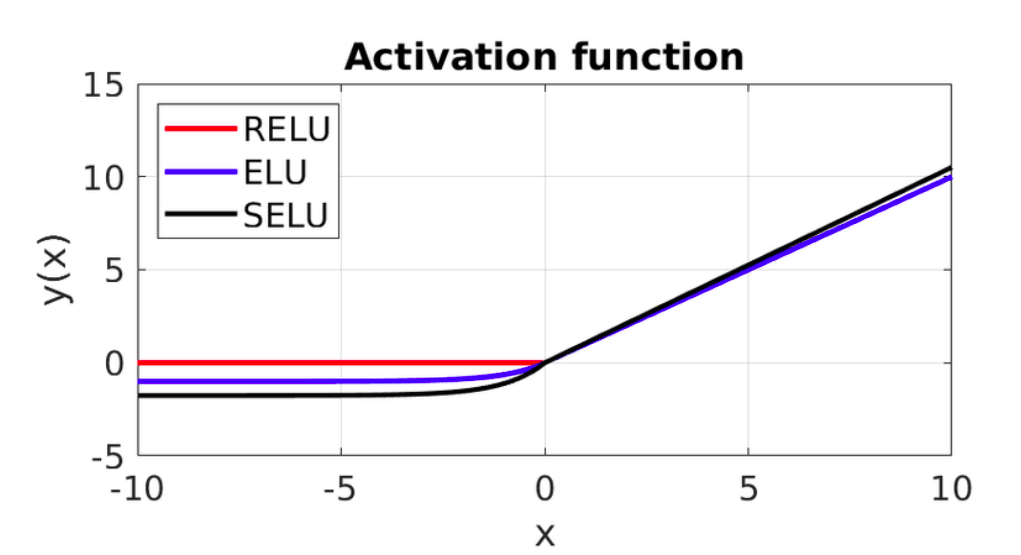

In [77]:
#Capa densa, la capa que recibe todo.
model.add(Dense(1))
#Función de activación
model.add(Activation('selu'))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['accuracy','mae',keras_metrics.recall()])

In [78]:
#Se entrena la red neuronal con el dataset "epochs" veces.
model.fit(trainX, trainY, epochs=16, batch_size=15, verbose=2)#verbose=0 para no imprimir los epoch

#Resultado de las predicciones sobre los datos de entrenamiento y los datos de prueba
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


Epoch 1/16


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


324/324 - 9s - loss: 0.0027 - accuracy: 0.6304 - mae: 0.0244 - recall: 0.0000e+00
Epoch 2/16
324/324 - 4s - loss: 0.0022 - accuracy: 0.6304 - mae: 0.0225 - recall: 0.0000e+00
Epoch 3/16
324/324 - 4s - loss: 0.0022 - accuracy: 0.6304 - mae: 0.0221 - recall: 0.0000e+00
Epoch 4/16
324/324 - 4s - loss: 0.0022 - accuracy: 0.6304 - mae: 0.0212 - recall: 0.0000e+00
Epoch 5/16
324/324 - 4s - loss: 0.0021 - accuracy: 0.6304 - mae: 0.0209 - recall: 0.0145
Epoch 6/16
324/324 - 4s - loss: 0.0021 - accuracy: 0.6304 - mae: 0.0210 - recall: 0.0192
Epoch 7/16
324/324 - 4s - loss: 0.0020 - accuracy: 0.6304 - mae: 0.0207 - recall: 0.0220
Epoch 8/16
324/324 - 5s - loss: 0.0020 - accuracy: 0.6304 - mae: 0.0207 - recall: 0.0287
Epoch 9/16
324/324 - 5s - loss: 0.0020 - accuracy: 0.6304 - mae: 0.0204 - recall: 0.0328
Epoch 10/16
324/324 - 4s - loss: 0.0021 - accuracy: 0.6304 - mae: 0.0204 - recall: 0.0414
Epoch 11/16
324/324 - 4s - loss: 0.0020 - accuracy: 0.6304 - mae: 0.0198 - recall: 0.0461
Epoch 12/16
32

Desnormalizamos los datos que anteriormente habían pasado a una escala de 0 a 1.

In [79]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Calculamos el Root Median Square Error.

 $$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

In [80]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 13.1584 RMSE
Test Score: 10.2674 RMSE


Teniendo en cuenta que el rango de mi data set va de 0 incendios a 222 incendios registrados en un solo día (el pico más alto). Consideramos que un error de 11.0396/222, es decir 0.049 es bueno.

**Por lo que nuestro modelo tiene una exactitud de 95.1% 🎉🎉🎉**

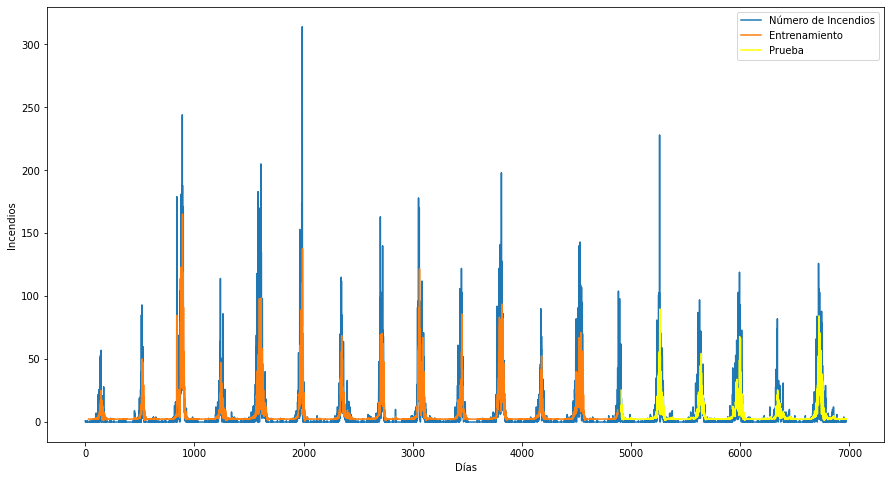

In [81]:
#Desplazamiento de datos para graficación
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#Desplazamiento de datos para graficación
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

#Plot
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dataset),label='Número de Incendios')
plt.plot(trainPredictPlot,label='Entrenamiento')
plt.plot(testPredictPlot,color='yellow',label='Prueba')
plt.xlabel('Días')
plt.ylabel('Incendios')
plt.legend()
plt.show()

# Conclusiones

Sarima no funcionó porque no es un buen modelo cuando se tienen tantos datos. evidentemente existe un patrón que se repite año tras año, y con Sarima habría sido mejor medir en lugar de días, los meses... y eso no nos interesaba porque queríamos obtener el valor de 1 día específico.

Para nuestra serie de tiempo, el algoritmo que mejor se adaptó fue el de LSTM.

# Referencias

[1] https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27|

[2] https://colah.github.io/posts/2015-08-Understanding-LSTMs/

[3] https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

[4] https://stats.stackexchange.com/questions/56302/what-are-good-rmse-values

[5] https://www.quora.com/Why-is-the-number-of-neurons-in-a-neural-network-recommended-to-be-a-power-of-two#:~:text=It%20is%20just%20because%20of,be%20powers%20of%20two%2C%20too.